In [21]:
import os
import csv
import networkx as nx
import pandas as pd
from random import shuffle

from IPython.display import display, SVG

from rdkit import Chem
from rdkit.Chem import AllChem
from rdkit.Chem import rdDepictor
from rdkit.Chem import Descriptors
from rdkit.Chem.Draw import rdMolDraw2D
from rdkit.Chem import Draw

import matplotlib.pyplot as plt
from matplotlib.backends.backend_pdf import PdfPages

## Data loading

In [2]:
data_3CLPro_7BQY_A_1_F = pd.read_csv("docking_data_idr/3CLPro_7BQY_A_1_F.csv")
data_NSP15_6W01_AB_1_F = pd.read_csv("docking_data_idr/NSP15_6W01_AB_1_F.csv")
data_NSP16_6W61_A_1_H = pd.read_csv("docking_data_idr/NSP16_6W61_A_1_H.csv")
data_PLPro_6W9C_A_2_F = pd.read_csv("docking_data_idr/PLPro_6W9C_A_2_F.csv")
smiles = pd.read_csv("docking_data_idr/ORD.mini.sorted.csv", header = 0, names = ["SMILE", "Title"])
print(data_3CLPro_7BQY_A_1_F.shape, data_NSP15_6W01_AB_1_F.shape, data_NSP16_6W61_A_1_H.shape,\
      data_PLPro_6W9C_A_2_F.shape, smiles.shape)

(2907, 13) (2928, 13) (2921, 13) (2869, 13) (2935, 2)


In [3]:
# There are some duplicates.
data_3CLPro_7BQY_A_1_F[data_3CLPro_7BQY_A_1_F[["Title"]].duplicated()]

,Title,Score_vina,rank_vina,percentile_vina,Score_fred,rank_fred,percentile_fred,Score_dock,rank_dock,percentile_dock,local_idr,global_idr,max_percentile
2491,ORD-MCULE-3967726014_1,-7.25,422.0,0.144,-10.961745,2595.0,0.884,-35.589,1505.0,0.483,0.934231,0.54347,0.884


In [4]:
smiles_3CLPro_7BQY_A_1_F = pd.merge(data_3CLPro_7BQY_A_1_F, smiles, how = 'inner', on = "Title")
smiles_NSP15_6W01_AB_1_F = pd.merge(data_NSP15_6W01_AB_1_F, smiles, how = 'inner', on = "Title")
smiles_NSP16_6W61_A_1_H  = pd.merge(data_NSP16_6W61_A_1_H, smiles, how = 'inner', on = "Title")
smiles_PLPro_6W9C_A_2_F  = pd.merge(data_PLPro_6W9C_A_2_F, smiles, how = 'inner', on = "Title")
print(smiles_3CLPro_7BQY_A_1_F.shape, smiles_NSP15_6W01_AB_1_F.shape, smiles_NSP16_6W61_A_1_H.shape,\
      smiles_PLPro_6W9C_A_2_F.shape)

(2908, 14) (2929, 14) (2922, 14) (2870, 14)


In [5]:
smiles_3CLPro_7BQY_A_1_F = smiles_3CLPro_7BQY_A_1_F.rename(columns={'Score_vina':'vina_3CLPro', 'Score_fred':'fred_3CLPro','Score_dock':'dock_3CLPro'})
smiles_NSP15_6W01_AB_1_F = smiles_NSP15_6W01_AB_1_F.rename(columns={'Score_vina':'vina_NSP15', 'Score_fred':'fred_NSP15','Score_dock':'dock_NSP15'})
smiles_NSP16_6W61_A_1_H  = smiles_NSP16_6W61_A_1_H.rename(columns={'Score_vina':'vina_NSP16', 'Score_fred':'fred_NSP16','Score_dock':'dock_NSP16'})
smiles_PLPro_6W9C_A_2_F  = smiles_PLPro_6W9C_A_2_F.rename(columns={'Score_vina':'vina_PLPro', 'Score_fred':'fred_PLPro','Score_dock':'dock_PLPro'})
print(smiles_3CLPro_7BQY_A_1_F.shape, smiles_NSP15_6W01_AB_1_F.shape, smiles_NSP16_6W61_A_1_H.shape,\
      smiles_PLPro_6W9C_A_2_F.shape)

(2908, 14) (2929, 14) (2922, 14) (2870, 14)


In [6]:
#For Nicholas
# from functools import reduce
# _ = reduce(lambda left,right: pd.merge(left,right,on="Title", how = 'inner'), \
#        [smiles_3CLPro_7BQY_A_1_F.iloc[:,[0,-1,1,4,7]], smiles_NSP15_6W01_AB_1_F.iloc[:,[0,-1,1,4,7]],\
#         smiles_NSP16_6W61_A_1_H.iloc[:,[0,-1,1,4,7]], smiles_PLPro_6W9C_A_2_F.iloc[:,[0,-1,1,4,7]]])
# _ = _[~_[['Title']].duplicated()] 

In [7]:
#_.iloc[:,[0,1,2,3,4,6,7,8,10,11,12]].to_csv("Multilabel_data.csv", index = False)

In [8]:
#Thresholding
smiles_3CLPro_7BQY_A_1_F = smiles_3CLPro_7BQY_A_1_F[smiles_3CLPro_7BQY_A_1_F['global_idr'] < 0.05].sort_values('global_idr')
smiles_NSP15_6W01_AB_1_F = smiles_NSP15_6W01_AB_1_F[smiles_NSP15_6W01_AB_1_F['global_idr'] < 0.05].sort_values('global_idr')
smiles_NSP16_6W61_A_1_H  = smiles_NSP16_6W61_A_1_H[smiles_NSP16_6W61_A_1_H['global_idr'] < 0.05].sort_values('global_idr')
smiles_PLPro_6W9C_A_2_F  = smiles_PLPro_6W9C_A_2_F[smiles_PLPro_6W9C_A_2_F['global_idr'] < 0.05].sort_values('global_idr')
print(smiles_3CLPro_7BQY_A_1_F.shape, smiles_NSP15_6W01_AB_1_F.shape, smiles_NSP16_6W61_A_1_H.shape,\
      smiles_PLPro_6W9C_A_2_F.shape)

(251, 14) (71, 14) (95, 14) (76, 14)


## Are molecules which pass global_idr threshold also highly ranked?
- Yes for the most part.

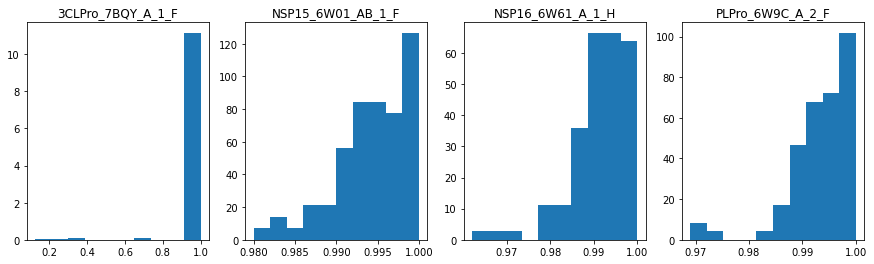

In [59]:
fig, axs = plt.subplots(1, 4, figsize=(15, 4))
axs[0].hist(smiles_3CLPro_7BQY_A_1_F.max_percentile, density = True)
axs[0].set_title("3CLPro_7BQY_A_1_F")
axs[1].hist(smiles_NSP15_6W01_AB_1_F.max_percentile, density = True)
axs[1].set_title("NSP15_6W01_AB_1_F")
axs[2].hist(smiles_NSP16_6W61_A_1_H.max_percentile, density = True)
axs[2].set_title("NSP16_6W61_A_1_H")
axs[3].hist(smiles_PLPro_6W9C_A_2_F.max_percentile, density = True)
axs[3].set_title("PLPro_6W9C_A_2_F");

## Writing PDFS

In [25]:
mols_3CLPro_7BQY_A_1_F = [Chem.MolFromSmiles(i) for i in smiles_3CLPro_7BQY_A_1_F['SMILE']]
mols_NSP15_6W01_AB_1_F = [Chem.MolFromSmiles(i) for i in smiles_NSP15_6W01_AB_1_F['SMILE']]
mols_NSP16_6W61_A_1_H  = [Chem.MolFromSmiles(i) for i in smiles_NSP16_6W61_A_1_H['SMILE']]
mols_PLPro_6W9C_A_2_F  = [Chem.MolFromSmiles(i) for i in smiles_PLPro_6W9C_A_2_F['SMILE']]

In [31]:
with PdfPages('IDR_Threshold_3CLPro_7BQY_A_1_F.pdf') as pdf:
    for i in range(len(mols_3CLPro_7BQY_A_1_F)):
        #Descriptors
        mollogp = Descriptors.MolLogP(mols_3CLPro_7BQY_A_1_F[i])
        qed = Descriptors.qed(mols_3CLPro_7BQY_A_1_F[i])
        #Drawing
        fig = Draw.MolToMPL(mols_3CLPro_7BQY_A_1_F[i], size=(300,300))
        plt.title(str(i+1))
        plt.text(0.01,0.15, "MolLogP: " + str(mollogp) + " | " + "QED: " + str(qed))
        plt.text(0.01,0.1,smiles_3CLPro_7BQY_A_1_F['SMILE'].values[i])
        plt.text(0.01,0.05,smiles_3CLPro_7BQY_A_1_F['Title'].values[i])
        pdf.savefig(fig, bbox_inches = "tight")  # saves the current figure into a pdf page
        plt.close()
        
with PdfPages('IDR_Threshold_NSP15_6W01_AB_1_F.pdf') as pdf:
    for i in range(len(mols_NSP15_6W01_AB_1_F)):
        mollogp = Descriptors.MolLogP(mols_NSP15_6W01_AB_1_F[i])
        qed = Descriptors.qed(mols_NSP15_6W01_AB_1_F[i])        
        fig = Draw.MolToMPL(mols_NSP15_6W01_AB_1_F[i], size=(300,300))
        plt.title(str(i+1))
        plt.text(0.01,0.15, "MolLogP: " + str(mollogp) + " | " + "QED: " + str(qed))        
        plt.text(0.01,0.1,smiles_NSP15_6W01_AB_1_F['SMILE'].values[i])
        plt.text(0.01,0.05,smiles_NSP15_6W01_AB_1_F['Title'].values[i])
        pdf.savefig(fig, bbox_inches = "tight")  # saves the current figure into a pdf page
        plt.close()
        
with PdfPages('IDR_Threshold_NSP16_6W61_A_1_H.pdf') as pdf:
    for i in range(len(mols_NSP16_6W61_A_1_H)):
        mollogp = Descriptors.MolLogP(mols_NSP16_6W61_A_1_H[i])
        qed = Descriptors.qed(mols_NSP16_6W61_A_1_H[i])        
        
        fig = Draw.MolToMPL(mols_NSP16_6W61_A_1_H[i], size=(300,300))
        plt.title(str(i+1))
        plt.text(0.01,0.15, "MolLogP: " + str(mollogp) + " | " + "QED: " + str(qed))
        plt.text(0.01,0.1,smiles_NSP16_6W61_A_1_H['SMILE'].values[i])
        plt.text(0.01,0.05,smiles_NSP16_6W61_A_1_H['Title'].values[i])
        pdf.savefig(fig, bbox_inches = "tight")  # saves the current figure into a pdf page
        plt.close()
        
with PdfPages('IDR_Threshold_PLPro_6W9C_A_2_F.pdf') as pdf:
    for i in range(len(mols_PLPro_6W9C_A_2_F)):
        mollogp = Descriptors.MolLogP(mols_PLPro_6W9C_A_2_F[i])
        qed = Descriptors.qed(mols_PLPro_6W9C_A_2_F[i])        
        
        fig = Draw.MolToMPL(mols_PLPro_6W9C_A_2_F[i], size=(300,300))
        plt.title(str(i+1))
        plt.text(0.01,0.15, "MolLogP: " + str(mollogp) + " | " + "QED: " + str(qed))
        plt.text(0.01,0.1,smiles_PLPro_6W9C_A_2_F['SMILE'].values[i])
        plt.text(0.01,0.05,smiles_PLPro_6W9C_A_2_F['Title'].values[i])
        pdf.savefig(fig, bbox_inches = "tight")  # saves the current figure into a pdf page
        plt.close()

In [18]:
# Multiple targets
multiple_targets = pd.read_csv("docking_data_idr/multiple_targets.csv")

In [19]:
multiple_targets

,Interaction,Molecules
0,"('NSP15_6W01_AB_1_F', '3CLPro_7BQY_A_1_F')","{'ORD-MCULE-6477680903_1', 'ORD-MCULE-37738418..."
1,"('NSP15_6W01_AB_1_F', 'NSP16_6W61_A_1_H')","{'ORD-MCULE-6477680903_1', 'ORD-MCULE-42620917..."
2,"('NSP15_6W01_AB_1_F', 'PLPro_6W9C_A_2_F')","{'ORD-MCULE-7416131701_1', 'ORD-MCULE-93119370..."
3,"('3CLPro_7BQY_A_1_F', 'NSP16_6W61_A_1_H')","{'ORD-MCULE-1562586832_1', 'ORD-MCULE-64776809..."
4,"('3CLPro_7BQY_A_1_F', 'PLPro_6W9C_A_2_F')","{'ORD-MCULE-5739750381_1', 'ORD-MCULE-91301999..."
5,"('NSP16_6W61_A_1_H', 'PLPro_6W9C_A_2_F')","{'ORD-MCULE-7968599617_1', 'ORD-MCULE-74161317..."
6,"('NSP15_6W01_AB_1_F', '3CLPro_7BQY_A_1_F', 'NS...","{'ORD-MCULE-6977725985_1', 'ORD-MCULE-74161317..."
7,"('NSP15_6W01_AB_1_F', '3CLPro_7BQY_A_1_F', 'PL...","{'ORD-MCULE-7416131701_1', 'ORD-MCULE-93119370..."
8,"('NSP15_6W01_AB_1_F', 'NSP16_6W61_A_1_H', 'PLP...","{'ORD-MCULE-7416131701_1', 'ORD-MCULE-93119370..."
9,"('3CLPro_7BQY_A_1_F', 'NSP16_6W61_A_1_H', 'PLP...","{'ORD-MCULE-7416131701_1', 'ORD-MCULE-93119370..."


In [29]:
len(interaction.split(","))

4

In [30]:
merged_dfs = []
with PdfPages('Multiple_Targets.pdf') as pdf:
    for i in range(multiple_targets.shape[0]):
        interaction = multiple_targets['Interaction'][i]
        mol_data = multiple_targets['Molecules'][i]
        
        #Filtered Dataframe according to multipletargets data
        arr = mol_data.replace("'","").replace("{","").replace("}","").replace(" ","").split(",")
        _ = pd.DataFrame({'Title':arr, 'Interaction':interaction})
        filtered_df = pd.merge(smiles, _, how = 'inner', on = "Title")
        merged_dfs.append(filtered_df.copy())
        
        smile_filter = filtered_df['SMILE'].values
        title_filter = filtered_df['Title'].values

        mols = [Chem.MolFromSmiles(i) for i in smile_filter]
        for j in range(len(mols)):
            mollogp = Descriptors.MolLogP(mols[j])
            qed = Descriptors.qed(mols[j])
            
            fig = Draw.MolToMPL(mols[j], size = (300,300))
            plt.title(interaction)
            plt.text(0.01,0.15, "MolLogP: " + str(mollogp) + " | " + "QED: " + str(qed))
            plt.text(0.01,0.1,smile_filter[j])
            plt.text(0.01,0.05,title_filter[j])
            pdf.savefig(fig, bbox_inches = "tight")
            plt.close()

## Writing csvs

In [37]:
merged_dfs[0]

,SMILE,Title,Interaction
0,c1ccc(cc1)C[C@@H](C(=O)NCc2ccc(cc2)Cl)NC(=O)[C...,ORD-MCULE-6977725985_1,"('NSP15_6W01_AB_1_F', '3CLPro_7BQY_A_1_F')"
1,c1ccc2cc(ccc2c1)S(=O)(=O)N3CCN(CC3)c4ccc(c(c4)...,ORD-MCULE-1708960826_1,"('NSP15_6W01_AB_1_F', '3CLPro_7BQY_A_1_F')"
2,c1ccc(cc1)C[C@@H](C(=O)NCc2ccc(cc2)F)NC(=O)[C@...,ORD-MCULE-6477680903_1,"('NSP15_6W01_AB_1_F', '3CLPro_7BQY_A_1_F')"
3,c1ccc(cc1)C[C@@H](C(=O)NCCC2=CCCCC2)NC(=O)[C@@...,ORD-MCULE-2409941333_1,"('NSP15_6W01_AB_1_F', '3CLPro_7BQY_A_1_F')"
4,c1ccc(cc1)C[C@@H](C(=O)NC2CCCCC2)NC(=O)[C@@H]3...,ORD-MCULE-9395623979_1,"('NSP15_6W01_AB_1_F', '3CLPro_7BQY_A_1_F')"
5,c1ccc(cc1)C(=O)[C@@H]2c3c(c(n(c3O)c4cccc5c4ccc...,ORD-MCULE-7416131701_1,"('NSP15_6W01_AB_1_F', '3CLPro_7BQY_A_1_F')"
6,Cc1ccc(c(c1)c2ccc3nc(c(n3c2)C[NH+]4CCN(CC4)C(=...,ORD-MCULE-1845027027_1,"('NSP15_6W01_AB_1_F', '3CLPro_7BQY_A_1_F')"
7,COc1ccc(cc1)c2c(n3cc(ccc3n2)c4ccccc4)C[NH+]5CC...,ORD-MCULE-5878589304_1,"('NSP15_6W01_AB_1_F', '3CLPro_7BQY_A_1_F')"
8,Cc1cccc(c1)C[NH+]2CCN(CC2)c3nc4c(n3Cc5cccc6c5c...,ORD-MCULE-9311937068_1,"('NSP15_6W01_AB_1_F', '3CLPro_7BQY_A_1_F')"
9,Cc1ccc(cc1)C[NH+]2CCN(CC2)c3nc4c(n3Cc5cccc6c5c...,ORD-MCULE-8959718627_1,"('NSP15_6W01_AB_1_F', '3CLPro_7BQY_A_1_F')"


In [42]:
_ = pd.concat(merged_dfs)
_.to_csv("Multiple_Targets_SMILES.csv", index = False)

In [16]:
smiles_PLPro_6W9C_A_2_F.to_csv("IDR_Threshold_PLPro_6W9C_A_2_F.csv", index = False)
smiles_NSP16_6W61_A_1_H.to_csv("IDR_Threshold_NSP16_6W61_A_1_H.csv", index = False)
smiles_NSP15_6W01_AB_1_F.to_csv("IDR_Threshold_NSP15_6W01_AB_1_F.csv", index = False)
smiles_3CLPro_7BQY_A_1_F.to_csv("IDR_Threshold_PLPro_3CLPro_7BQY_A_1_F.csv", index = False)